In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import time
import shutil
import pathlib
import itertools
import cv2
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", message="modules missing")

print ('modules loaded')

modules loaded


In [ ]:
input_shape = (224, 224, 3)
num_classes = 15
batch_size = 35
epochs = 4



In [ ]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)


    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):



    # define model parameters
    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size


    def scalar(img):
        return img


    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)


    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(gen):


    # return classes , images to be displayed
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    # calculate number of displayed samples
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [ ]:
def plot_training(hist):



    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
data_dir = '/content/drive/MyDrive/PlantVillage'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print('Error:', e)

Found 3936 validated image filenames belonging to 15 classes.
Found 492 validated image filenames belonging to 15 classes.
Found 493 validated image filenames belonging to 15 classes.


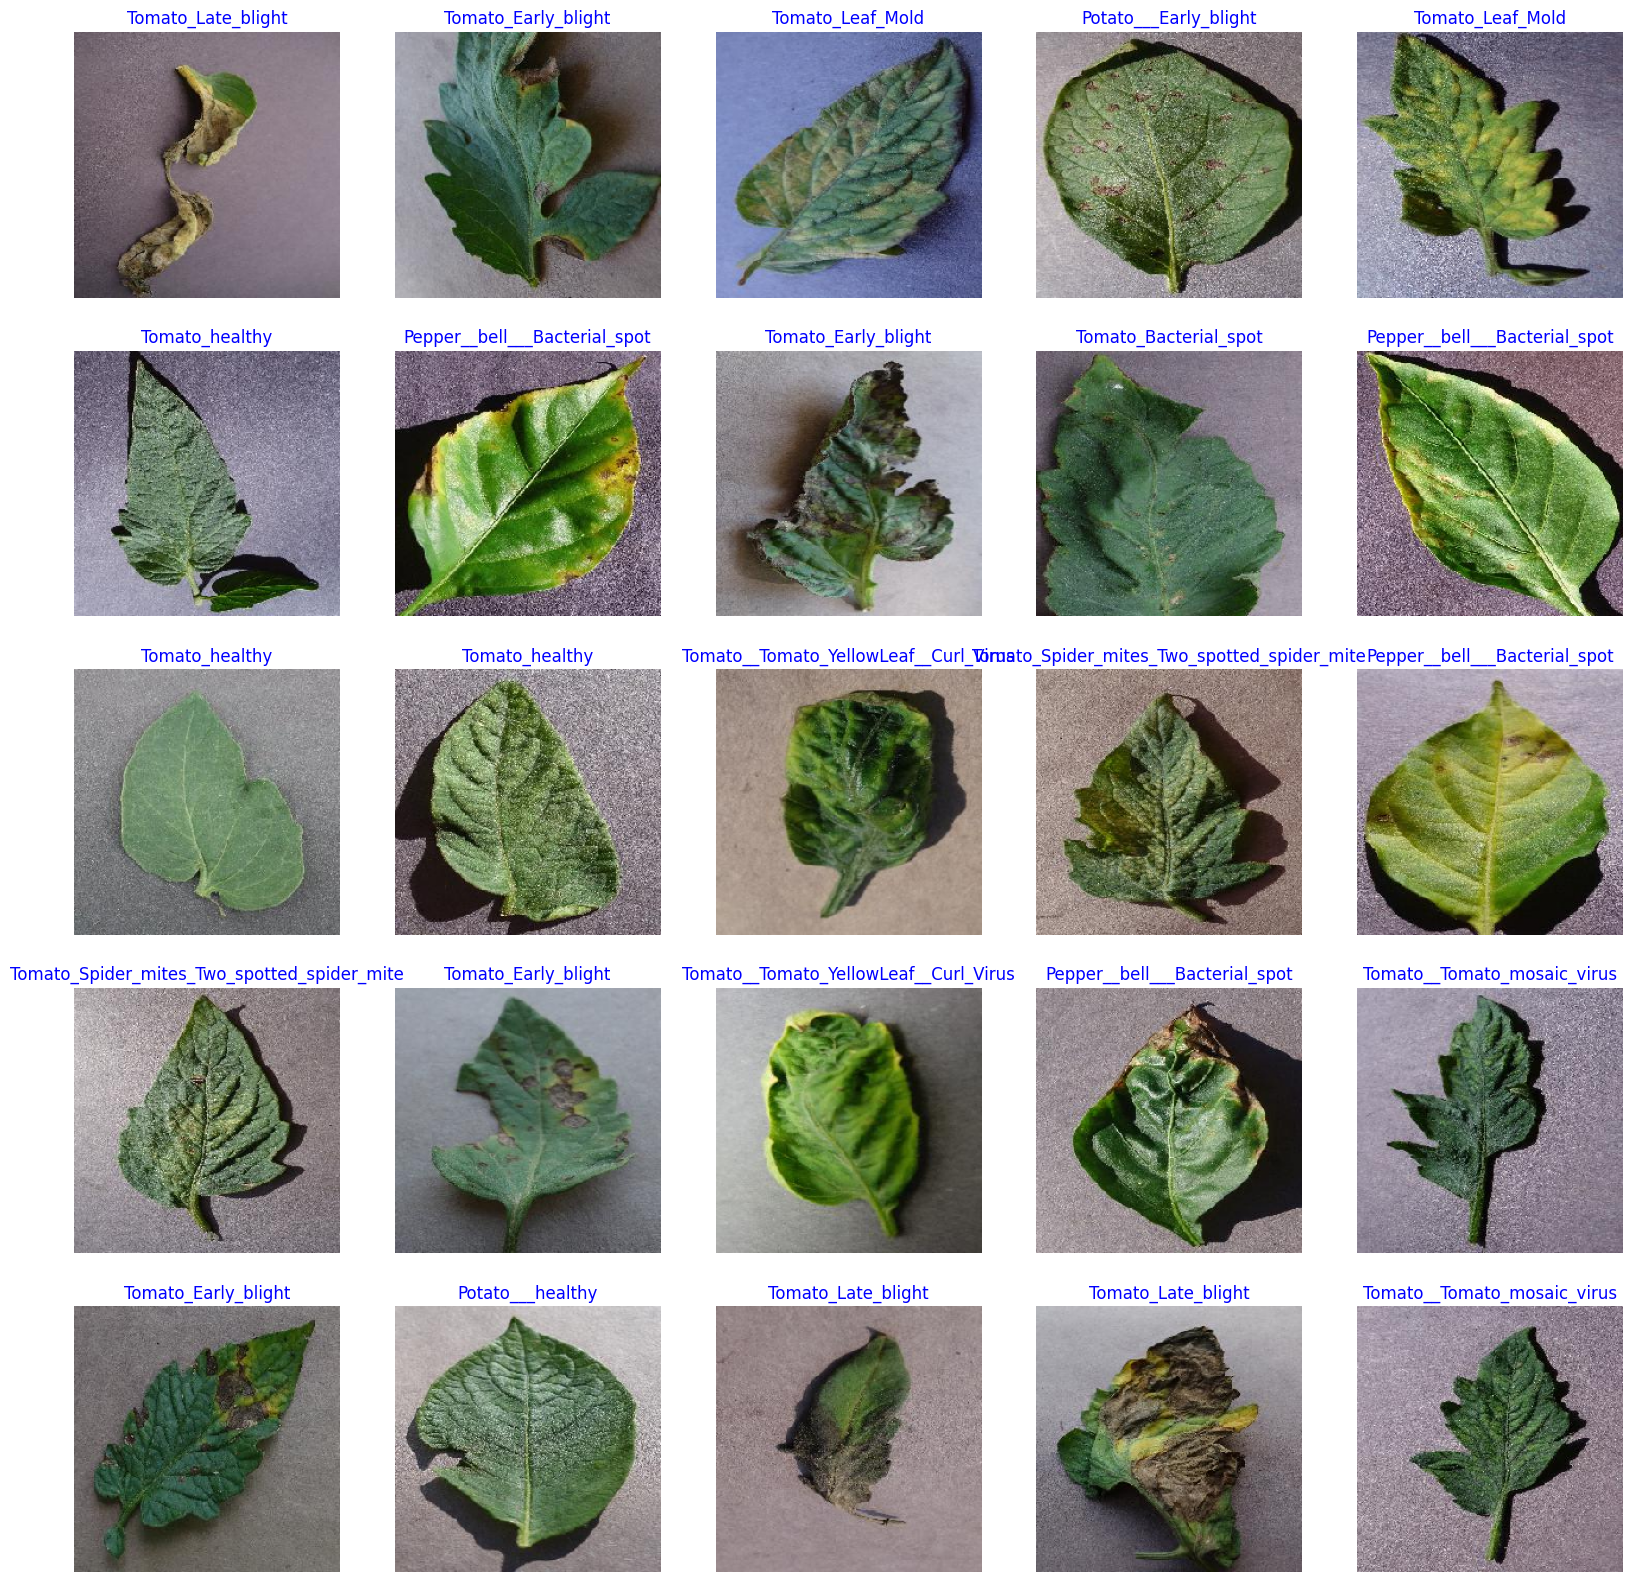

In [ ]:
show_images(train_gen)

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_base.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg_base.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])model = Model(inputs=vgg_base.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
batches = int(np.ceil(len(train_gen.labels) / batch_size)) # number of training batch to run per epoch

In [ ]:
history = model.fit(train_gen, epochs= epochs,
                    validation_data= valid_gen)

Epoch 1/4
99/99 [==============================] - 2919s 29s/step - loss: 11.7488 - accuracy: 0.4129 - val_loss: 1.0791 - val_accuracy: 0.6707
Epoch 2/4
99/99 [==============================] - 2864s 29s/step - loss: 1.5915 - accuracy: 0.5485 - val_loss: 0.9428 - val_accuracy: 0.7195
Epoch 3/4
99/99 [==============================] - 2837s 29s/step - loss: 1.3229 - accuracy: 0.5988 - val_loss: 0.7087 - val_accuracy: 0.7846
Epoch 4/4
99/99 [==============================] - 2840s 29s/step - loss: 1.2067 - accuracy: 0.6367 - val_loss: 0.7635 - val_accuracy: 0.7805


In [ ]:
model.save_weights('VGG_PV.h5')

In [ ]:
model.save('/content/drive/MyDrive')

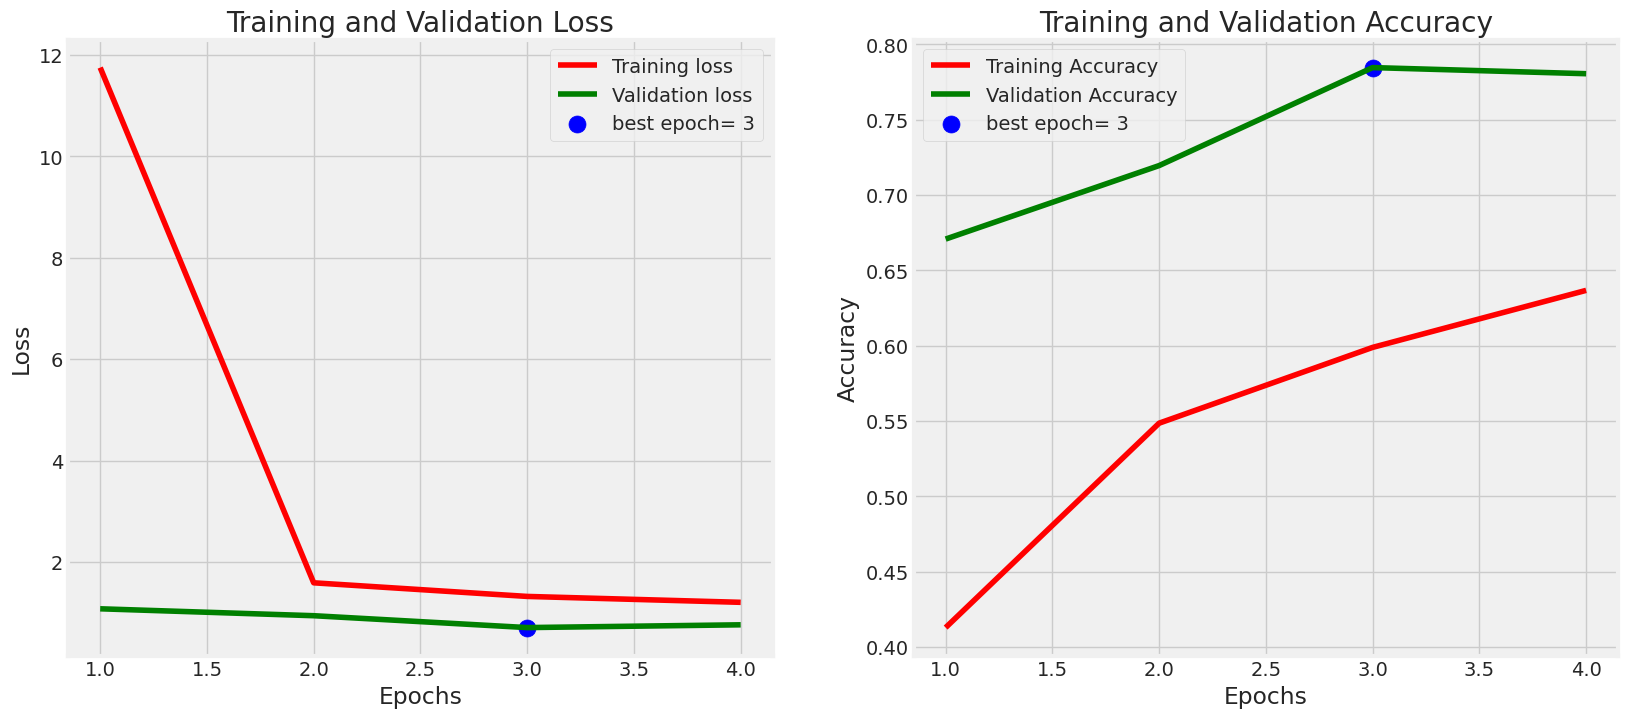

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


13/17 [=====================>........] - ETA: 1:39 - loss: 0.7635 - accuracy: 0.7805

17/17 [==============================] - 314s 19s/step - loss: 0.8239 - accuracy: 0.7485


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-27-4f04c24daf97>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[ 6  1  7  2  1  1  9  7 14  9 14 14  9 10 14  2 10 10  2  6 13  9 13  0
 13  1  7  7  7  9 12  3  2  5  6  7  0  4 11  0  8  6  2 14  8 14  7 14
  7  6  7  9  0  3  5  2  0  6 13  5  2  3  7  7  7  9  5 11 12  0 13 14
  5  5  1  6  9  2  7 14 11  1  8  7  4  3  9  1  8 10 11 10 10  5 10  5
  6  4  6 13 12 13 14  6 14  3 14  5  6  6 11  0 10 12 11  7  2 13  3 13
  9  8 14  5 10  0 14 14  3  7  7 14 10 11 13  0  2 11  7 12  0  0  6  8
 13  8  3 12 10  8  2 11 12 13 12  0 10  7 14  2 14  2 12  8  7  3  5  6
 12  6 14 14  3 11 12 14  3  0  2  0  6  6 10  7  9  9  9  7  2  7  6  7
 14  2 11  9 10 13 14 11 14  7  6  3  3  7 14  8  6  6  6 14  2 11  9  5
  2 10  8  1 14  0  3  3  7 12  4 14 10  7  2  0  2  1 14  7 11 12 10  6
 11  8  0 12  6  6 14  1 14  3  2  3 14  1 11  2 14  3 12 13  6  5 12 11
  5  0  3  7  7 14  1  5 12  9  7  1  2  3  6  0 11  4  6  9  1 14 11  5
  2  6  7 14  0 14 12 14 13 11  0  2  7  6  0  0  5 12 10  3  6 13 13 14
  1  8  4  4  8  2  3  2  8  1 10 13  5 14  2  4 14

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.71      0.83      0.77        30
                     Pepper__bell___healthy       0.74      0.85      0.79        20
                      Potato___Early_blight       0.82      0.94      0.87        33
                       Potato___Late_blight       0.84      0.74      0.79        35
                           Potato___healthy       0.85      0.73      0.79        15
                      Tomato_Bacterial_spot       0.93      0.74      0.82        38
                        Tomato_Early_blight       0.56      0.59      0.57        39
                         Tomato_Late_blight       0.61      0.69      0.65        45
                           Tomato_Leaf_Mold       0.86      0.58      0.69        31
                  Tomato_Septoria_leaf_spot       0.79      0.55      0.65        42
Tomato_Spider_mites_Two_spotted_spider_mite       0.66      0.63

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'Plant Village Disease'
acc = test_score[1] * 100
save_path = '/content/drive/MyDrive'

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as /content/drive/MyDrive/i-Plant Village Disease-74.85.h5
weights were saved as /content/drive/MyDrive/i-Plant Village Disease-weights.h5
